In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import functools
import seaborn as sn
from tqdm import tqdm
from numpy import logical_and as land, logical_or as lor

In [2]:
df_tweets = pd.read_csv('data/tweets_no_dupl.csv', sep='#')
df_users = pd.read_csv('data/users_clean.csv', sep='#')

# Tweets csv cleaning

## id
In the id column there are only two missing values. Since the column is not meaningful for the analysis phase, the column is dropped.

## user_id
In the user_id column there are a lot of missing values, wrong values (non-numerical ids) and 210778 user ids do not have any correspondence with users file. Nevertheless, these records have been kept because the other columns could be useful for future analyses.



In [59]:
df_tweets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712348 entries, 0 to 11712347
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   id              11712346 non-null  object
 1   user_id         11495314 non-null  object
 2   retweet_count   11275326 non-null  object
 3   reply_count     11064671 non-null  object
 4   favorite_count  11064981 non-null  object
 5   num_hashtags    10655073 non-null  object
 6   num_urls        11063920 non-null  object
 7   num_mentions    10858432 non-null  object
 8   created_at      11712348 non-null  object
 9   text            11182415 non-null  object
dtypes: object(10)
memory usage: 893.6+ MB


In [3]:
df_tweets.drop(columns=['id'], inplace=True)

Select records which have both user_id and text values which are null

In [61]:
df_tweets[np.logical_and(df_tweets['user_id'].isnull(), df_tweets['text'].isnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56118 entries, 42 to 11712030
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         0 non-null      object
 1   retweet_count   51567 non-null  object
 2   reply_count     25737 non-null  object
 3   favorite_count  50960 non-null  object
 4   num_hashtags    392 non-null    object
 5   num_urls        26107 non-null  object
 6   num_mentions    466 non-null    object
 7   created_at      56118 non-null  object
 8   text            0 non-null      object
dtypes: object(9)
memory usage: 4.3+ MB


Merge users table with tweets table by user_id

In [62]:
df_users.id = df_users.id.astype(str)
merged = df_tweets.merge(df_users, left_on='user_id', right_on='id', how='left')

In [63]:
df_tweets.shape

(11712348, 9)

In [64]:
merged.shape

(11712348, 16)

Number of `user_id` that have no correspondance in users file.

In [65]:
len(merged[merged['id'].isnull()].user_id.unique())

210778

## File checkpoint

In [4]:
df_tweets.to_csv(path_or_buf='data/tweets_no_ids.csv', sep='#', index=False)
df_users.to_csv(path_or_buf='data/users_no_ids.csv', sep='#', index=False)

In [5]:
df_tweets = pd.read_csv('data/tweets_no_ids.csv', sep='#')
df_users = pd.read_csv('data/users_no_ids.csv', sep='#')

# Convert to float
Cast column values to float (there are number to big for int) and set to -1.0 when there is a value which is not a number or an uncastable value (e.g. string)

In [166]:
def to_float(x):
    try:
        x=float(x)
        if(np.isnan(x)):
            return float(-1)
        else:
            return x
    except:
        return float(-1)

In [7]:
df_tweets['retweet_count_conv'] = df_tweets.retweet_count.apply(to_float)

In [8]:
df_tweets['reply_count_conv'] = df_tweets.reply_count.apply(to_float)

In [9]:
df_tweets['favorite_count_conv'] = df_tweets.favorite_count.apply(to_float)

In [215]:
df_tweets['num_hashtags_conv'] = df_tweets.num_hashtags.apply(to_float)

In [241]:
df_tweets['num_urls_conv'] = df_tweets.num_urls.apply(to_float)

In [242]:
df_tweets['num_mentions_conv'] = df_tweets.num_mentions.apply(to_float)

In [195]:
df_tweets['created_at_conv'] = pd.to_datetime(df_tweets['created_at']).astype(np.int64)

## File checkpoint

In [196]:
df_tweets.to_csv(path_or_buf='data/tweets_to_float.csv', sep='#', index=False)
df_users.to_csv(path_or_buf='data/users_to_float.csv', sep='#', index=False)

In [9]:
df_tweets = pd.read_csv('data/tweets_to_float.csv', sep='#')
df_users = pd.read_csv('data/users_to_float.csv', sep='#')

# Correlation tests

In [333]:
def eval_correlation(df_corr, method='pearson'):
    correlation_matrix = df_corr.corr(method=method)
    sn.heatmap(correlation_matrix, annot=True)
    plt.show()

We have noticed a lot of huge values in the `retweet_count_conv` **(RCC)** column. By analysing statistics of real tweets on the web, we have decide to perform further analysis on records having a RCC value lower than 1e7 (https://en.wikipedia.org/wiki/List_of_most-retweeted_tweets)

In [334]:
threshold = 1e7
df_correlation = pd.DataFrame()
df_correlation = df_tweets[functools.reduce(np.logical_and,
                                (np.logical_and(df_tweets['retweet_count_conv'] != -1, df_tweets['retweet_count_conv'] < threshold),
                                np.logical_and(df_tweets['reply_count_conv'] != -1, df_tweets['reply_count_conv'] < threshold),
                                np.logical_and(df_tweets['favorite_count_conv'] != -1, df_tweets['favorite_count_conv'] < threshold)))
                    ][['retweet_count_conv', 'reply_count_conv', 'favorite_count_conv']]
df_correlation.head()

,retweet_count_conv,reply_count_conv,favorite_count_conv
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,114.0,0.0,0.0


In [335]:
df_correlation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10297438 entries, 0 to 11712347
Data columns (total 3 columns):
 #   Column               Dtype  
---  ------               -----  
 0   retweet_count_conv   float64
 1   reply_count_conv     float64
 2   favorite_count_conv  float64
dtypes: float64(3)
memory usage: 314.3 MB


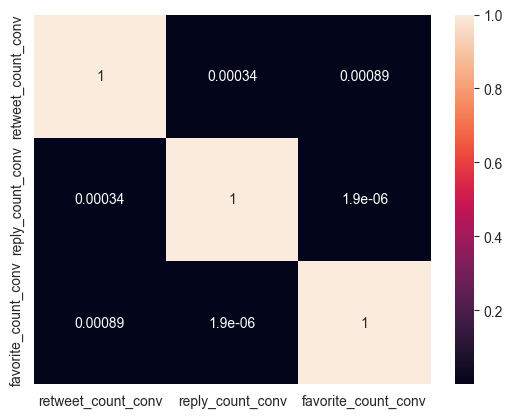

In [336]:
eval_correlation(df_correlation)

C:\Users\Alessandro\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4868: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


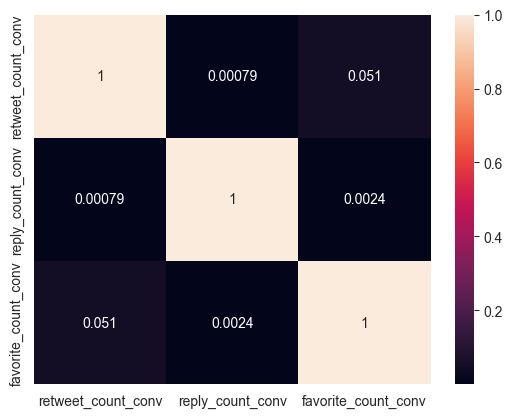

In [337]:
eval_correlation(df_correlation, 'kendall')

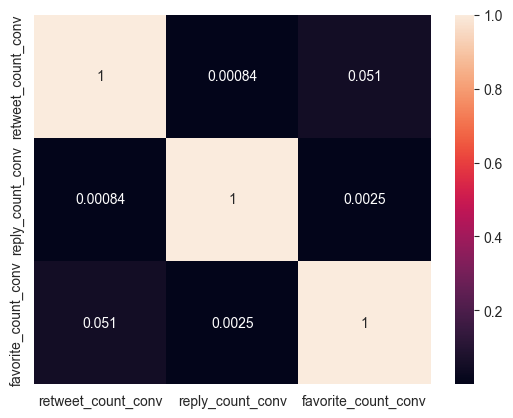

In [338]:
eval_correlation(df_correlation, 'spearman')

# Utilities

Plot a histogram w.r.t. a single attribute passed as parameter.

In [10]:
def plot_hist(dataframe, attribute_name, log=False):
    df = pd.DataFrame()

    if log:
        log_attribute_name = attribute_name+'_log'
        df[log_attribute_name] = np.log(dataframe[attribute_name].values)

        attribute_name = log_attribute_name
        df[attribute_name] = df[attribute_name].replace(-np.inf, 0)

    else:
        df[attribute_name] = dataframe[attribute_name].values
    n_bins = math.ceil(np.log2(len(df[attribute_name])) + 1) #Sturges' rule
    df.hist(attribute_name, bins = n_bins, log=True)

In [11]:
def plot_boxplot(df,col,log=False):
    #Plot the distribution of the indicated column
    plt.boxplot(df_tweets[df[col] != -1.0][col], showmeans=True)
    if log:
        plt.yscale('log')
    plt.show()

In [12]:
def show_statistics(df, col, log=False):
    #Extract statistical indicators from the indicated column
    mean = np.mean(df[col].values)
    median = np.median(df[col].values)
    print("mean: " + str(mean))
    print("median: " + str(median))
    plot_boxplot(df,col, log)

In [13]:
def fix_values(df, col, replace_condition=None, replace_value=None):
    #Substitute all the -1.0 values (missing values) with the median
    if replace_condition is None:
        median = np.median(df[col].values)
        df[col] = df[col].replace({-1.0: median})
    else:
        if replace_value is None:
            replace_value = df[~replace_condition][col].median()
        df.loc[replace_condition, col] = replace_value

    return df

In [14]:
def check_var_attribute(df, attribute_name):

    df = df[land(land(df[attribute_name].isnull() != True, df[attribute_name] != np.inf), df[attribute_name] != -1)]
    df = df[['user_id', attribute_name]]
    df = df.groupby(by=['user_id']).agg(["mean", "median", "var"])[attribute_name]

    return df

In [15]:
def replace_with_user_median(df_to_replace, attribute_name, threshold=1e7, replace_condition=None):

    if replace_condition is None:
        replace_condition = lor(df_to_replace[attribute_name] == -1, df_to_replace[attribute_name] > threshold)

    condition_users = df_to_replace.user_id.isin(df_to_replace[replace_condition].user_id)


    keep_condition = ~replace_condition
    glob_median = df_to_replace[keep_condition][attribute_name].median()

    condition_for_median = land(keep_condition, condition_users)
    df_stats = df_to_replace[condition_for_median].groupby(by=['user_id']).agg(["median", "var"])[attribute_name]

    df_to_replace = df_to_replace.merge(df_stats, left_on='user_id', right_on='user_id', how='left')
    condition_one_tweet = land(df_to_replace['var'].isnull() == True, condition_users)
    df_to_replace.loc[condition_one_tweet, attribute_name] = glob_median

    condition3 = land(df_to_replace[attribute_name] != glob_median, condition_users)
    df_to_replace.loc[condition3, attribute_name] = df_to_replace[condition3]['median']

    df_to_replace.drop(columns=['median','var'], inplace=True)

    return df_to_replace

# Clean retweet_counts column

In [16]:
threshold = 1e7

mean: inf
median: 0.0


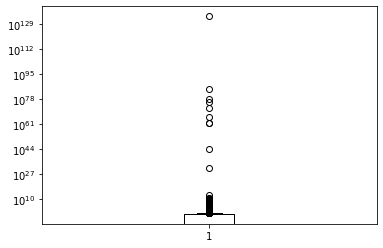

In [17]:
show_statistics(df_tweets,'retweet_count_conv', log=True)

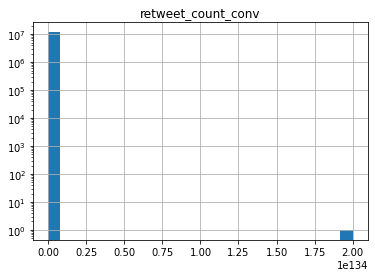

In [18]:
plot_hist(df_tweets[df_tweets['retweet_count_conv']!=np.inf], 'retweet_count_conv')

As it is possible to see the distribution is positively skewed. Considering the statistical indicators, it is clear that the mean is too much influenced by outliers so the median has been taken in account.

In [19]:
df_tweets = replace_with_user_median(df_tweets, 'retweet_count_conv', threshold=threshold)

c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\prog

mean: 60.060430709538345
median: 0.0


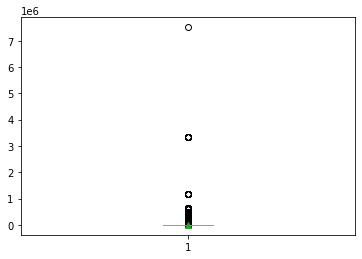

In [20]:
show_statistics(df_tweets,'retweet_count_conv')

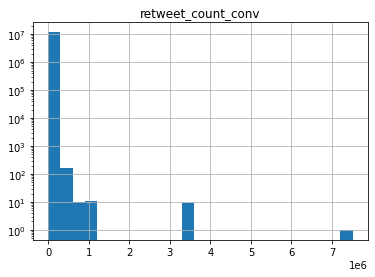

In [21]:
plot_hist(df_tweets, 'retweet_count_conv')

In [22]:
df_tweets.drop(columns = ['retweet_count'], inplace=True)

Now we have `retweet_count_replaced` with all numeric values. We have many values that seems to be "noise" but before replacing them we want to explore the correlation with other attributes related to the tweet popularity which are  `reply_count` and `favourite_count`. So this task is postponed. Instead for the missing values (-1) we have checked if the same user has other tweets in the dataset to extract statistics from them. If there are not other tweets or there are only tweets with missing values the median is set as default.

# Clean reply_count column

In [23]:
threshold = 1e5

mean: inf
median: 0.0


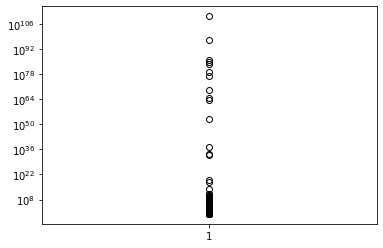

In [24]:
show_statistics(df_tweets,'reply_count_conv', log=True)

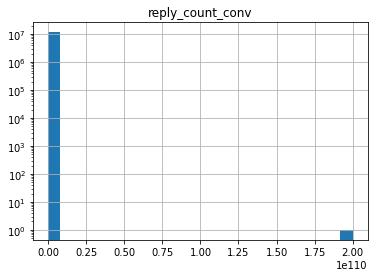

In [25]:
plot_hist(df_tweets[df_tweets['reply_count_conv']!=np.inf], 'reply_count_conv')

In [26]:
df_tweets = replace_with_user_median(df_tweets, 'reply_count_conv', threshold=threshold)

c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\prog

mean: 0.011026183648231764
median: 0.0


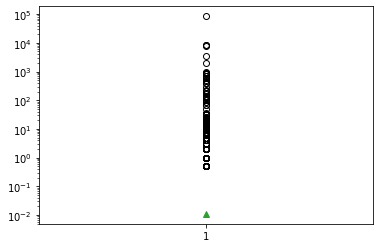

In [27]:
show_statistics(df_tweets,'reply_count_conv', True)

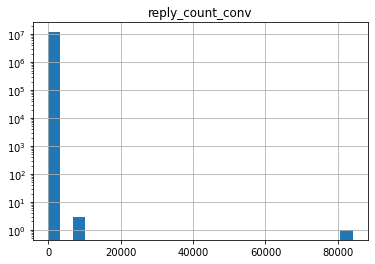

In [28]:
plot_hist(df_tweets, 'reply_count_conv')

In [29]:
df_tweets.drop(columns = ['reply_count'], inplace=True)

# Clean favorite_count column

In [30]:
threshold = 1e6

mean: inf
median: 0.0


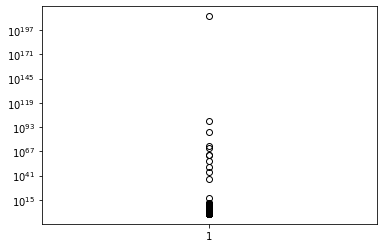

In [31]:
show_statistics(df_tweets,'favorite_count_conv', log=True)

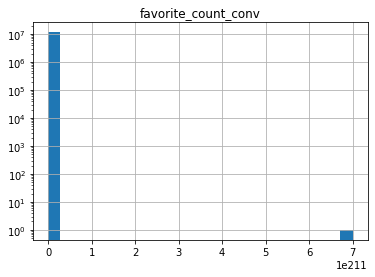

In [32]:
plot_hist(df_tweets[df_tweets['favorite_count_conv']!=np.inf], 'favorite_count_conv')

In [33]:
df_tweets = replace_with_user_median(df_tweets, 'favorite_count_conv', threshold=threshold)

c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\users\al\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


mean: 0.28765192939963874
median: 0.0


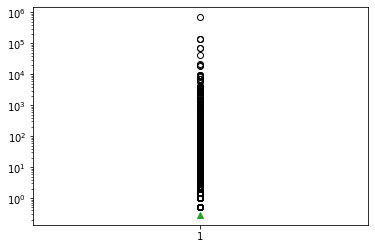

In [34]:
show_statistics(df_tweets,'favorite_count_conv', True)

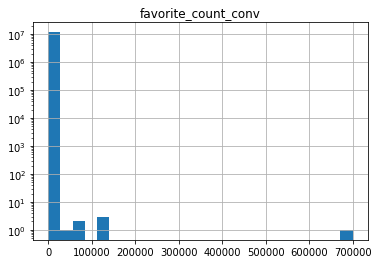

In [35]:
plot_hist(df_tweets, 'favorite_count_conv')

In [36]:
df_tweets.drop(columns = ['favorite_count'], inplace=True)

# File checkpoint

In [37]:
df_tweets.to_csv(path_or_buf='data/tweets_clean_counts.csv', sep='#', index=False)

In [38]:
df_tweets = pd.read_csv('data/tweets_clean_counts.csv', sep='#')

# Created at

<AxesSubplot:>

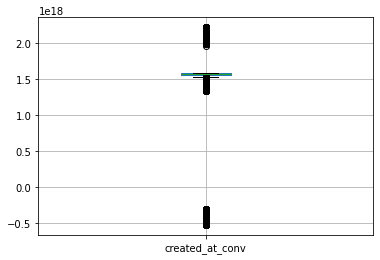

In [39]:
df_tweets.boxplot(['created_at_conv'])

In [40]:
twitter_foundation = pd.to_datetime(["20060321"]).astype(np.int64)[0]
sep_2022 = pd.to_datetime(["20220915"]).astype(np.int64)[0]
twitter_foundation

C:\Users\al\AppData\Local\Temp/ipykernel_22736/559833227.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  twitter_foundation = pd.to_datetime(["20060321"]).astype(np.int64)[0]
C:\Users\al\AppData\Local\Temp/ipykernel_22736/559833227.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  sep_2022 = pd.to_datetime(["20220915"]).astype(np.int64)[0]


1142899200000000000

In [42]:
replace_condition= lor(df_tweets.created_at_conv < twitter_foundation, df_tweets.created_at_conv > sep_2022)
df_tweets = replace_with_user_median(df_tweets, 'created_at_conv', replace_condition=replace_condition )

<AxesSubplot:>

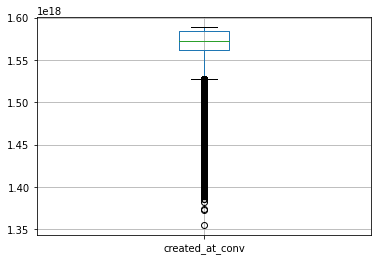

In [43]:
df_tweets.boxplot(['created_at_conv'])

In [46]:
df_tweets['created_at'] = pd.to_datetime(df_tweets.created_at_conv)

## Check that user tweets have created_at set after its subscription to twitter

In [78]:
df_users.id = df_users.id.astype(str)
df_merged = df_tweets.merge(df_users, left_on='user_id', right_on='id', how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11712348 entries, 0 to 11712347
Data columns (total 17 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            object 
 1   created_at_x       object 
 2   text               object 
 3   retweet_count      int32  
 4   reply_count        int32  
 5   favorite_count     int32  
 6   num_hashtags       int32  
 7   num_urls           int32  
 8   num_mentions       int32  
 9   created_at_conv_x  float64
 10  id                 object 
 11  name               object 
 12  lang               object 
 13  bot                float64
 14  created_at_y       object 
 15  statuses_count     float64
 16  created_at_conv_y  float64
dtypes: float64(4), int32(6), object(7)
memory usage: 1.3+ GB


In [80]:
df_merged[df_merged.created_at_conv_x < df_merged.created_at_conv_y]

,user_id,created_at_x,text,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at_conv_x,id,name,lang,bot,created_at_y,statuses_count,created_at_conv_y


In [81]:
df_tweets[df_tweets.created_at_conv == df_tweets.created_at_conv.max()]

,user_id,created_at,text,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at_conv
349936,476876406,2020-05-03 10:36:12.000,RT @people: It's a princess! William and Kate ...,2,0,0,1,1,1,1.588502e+18


In [82]:
df_tweets[df_tweets.created_at_conv == df_tweets.created_at_conv.min()]

,user_id,created_at,text,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at_conv
2430052,10935572,2012-12-08 13:57:21.000,I am at work,0,0,0,0,0,0,1.354975e+18


# File checkpoint

In [47]:
df_tweets.to_csv(path_or_buf='data/tweets_clean_created_at.csv', sep='#', index=False)

In [48]:
df_tweets = pd.read_csv('data/tweets_clean_created_at.csv', sep='#')

# Number of hashtags

An hashtag is composed by at least 2 characters, the `#` and an alphanumeric symbol. Since the 8th of november 2017 a tweet is made by at most 280 characters, before 2017, the maximum was 140. So the maximum number of hashtags in a tweet before 2017-11-8 should be 70, after 2017-11-8 140.

mean: inf
median: 0.0


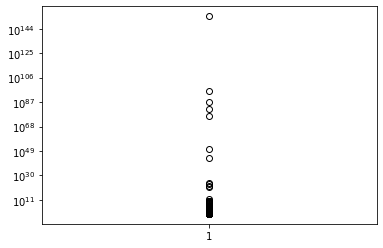

In [49]:
show_statistics(df_tweets, 'num_hashtags_conv', log=True)

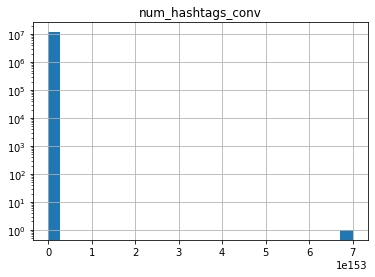

In [50]:
plot_hist(df_tweets[df_tweets.num_hashtags_conv != np.inf], 'num_hashtags_conv')

In [51]:
double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]

C:\Users\al\AppData\Local\Temp/ipykernel_22736/1499415200.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]


In [52]:
max_hash_num = 140/3

# Conditions
date_cond = df_tweets.created_at_conv < double_char_date
max_cond = df_tweets.num_hashtags_conv > max_hash_num
wrong_cond = df_tweets.num_hashtags_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_hashtags_conv.median()

df_tweets = fix_values(df_tweets, 'num_hashtags_conv', replace_cond, replace_value)

In [53]:
max_hash_num = 280/3

# Conditions
date_cond = df_tweets.created_at_conv > double_char_date
max_cond = df_tweets.num_hashtags_conv > max_hash_num
wrong_cond = df_tweets.num_hashtags_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_hashtags_conv.median()

df_tweets = fix_values(df_tweets, 'num_hashtags_conv', replace_cond, replace_value)

mean: 0.1587772152944909
median: 0.0


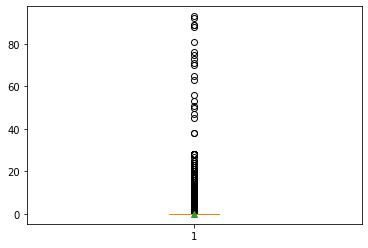

In [54]:
show_statistics(df_tweets, 'num_hashtags_conv')

In [55]:
df_tweets[df_tweets.num_hashtags_conv == df_tweets.num_hashtags_conv.max()]

,user_id,num_hashtags,num_urls,num_mentions,created_at,text,retweet_count_conv,reply_count_conv,favorite_count_conv,num_hashtags_conv,num_urls_conv,num_mentions_conv,created_at_conv
199894,27164845,093,0.0,0,2019-10-03 07:08:56.000,Man ion feel like going to work tomorrow that ...,0.0,0.0,0.0,93.0,0.0,0.0,1.570087e+18


In [56]:
df_tweets.drop(columns = ['num_hashtags'], inplace=True)

# Number of mentions

A mention is composed by at least 2 characters, the `@` and an alphanumeric symbol. Since the 8th of november 2017 a tweet is made by at most 280 characters, before 2017, the maximum was 140. So the maximum number of mention in a tweet before 2017-11-8 should be 70, after 2017-11-8 140.

mean: inf
median: 0.0


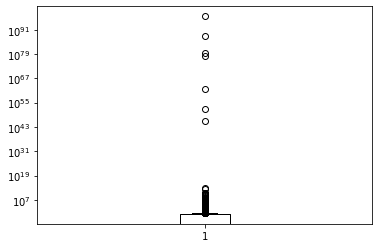

In [57]:
show_statistics(df_tweets, 'num_mentions_conv', log=True)

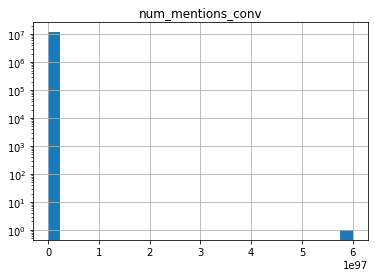

In [58]:
plot_hist(df_tweets[df_tweets.num_mentions_conv != np.inf], 'num_mentions_conv')

In [59]:
double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]

C:\Users\al\AppData\Local\Temp/ipykernel_22736/1499415200.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]


In [60]:
max_mentions_num = 140/3

# Conditions
date_cond = df_tweets.created_at_conv < double_char_date
max_cond = df_tweets.num_mentions_conv > max_mentions_num
wrong_cond = df_tweets.num_mentions_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_mentions_conv.median()

df_tweets = fix_values(df_tweets, 'num_mentions_conv', replace_cond, replace_value)

In [61]:
max_mentions_num = 280/3

# Conditions
date_cond = df_tweets.created_at_conv > double_char_date
max_cond = df_tweets.num_mentions_conv > max_mentions_num
wrong_cond = df_tweets.num_mentions_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_mentions_conv.median()

df_tweets = fix_values(df_tweets, 'num_mentions_conv', replace_cond, replace_value)

mean: 0.481402277323044
median: 0.0


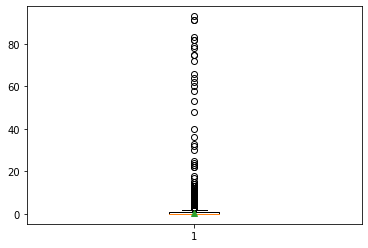

In [62]:
show_statistics(df_tweets, 'num_mentions_conv')

In [63]:
df_tweets[df_tweets.num_mentions_conv == df_tweets.num_mentions_conv.max()]

,user_id,num_urls,num_mentions,created_at,text,retweet_count_conv,reply_count_conv,favorite_count_conv,num_hashtags_conv,num_urls_conv,num_mentions_conv,created_at_conv
10607806,243926487,1.0,093,2020-01-23 12:26:28.000,Are you a leader or a follower? — Depends on t...,0.0,0.0,0.0,0.0,1.0,93.0,1.579782e+18


In [64]:
df_tweets.drop(columns = ['num_mentions'], inplace=True)

# Num URLS

A URL is composed by at least 3 characters, like `a.co`. Since the 8th of november 2017 a tweet is made by at most 280 characters, before 2017, the maximum was 140. So the maximum number of urls in a tweet before 2017-11-8 should be 35, after 2017-11-8 70.

mean: inf
median: 0.0


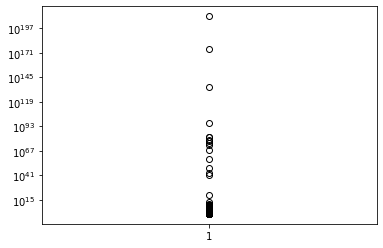

In [65]:
show_statistics(df_tweets, 'num_urls_conv', log=True)

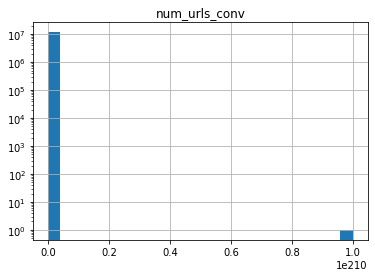

In [66]:
plot_hist(df_tweets[df_tweets.num_urls_conv != np.inf], 'num_urls_conv')

In [67]:
double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]

C:\Users\al\AppData\Local\Temp/ipykernel_22736/1499415200.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  double_char_date = pd.to_datetime(["20171108"]).astype(np.int64)[0]


In [68]:
max_url_num = 140/5

# Conditions
date_cond = df_tweets.created_at_conv < double_char_date
max_cond = df_tweets.num_urls_conv > max_url_num
wrong_cond = df_tweets.num_urls_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_urls_conv.median()

df_tweets = fix_values(df_tweets, 'num_urls_conv', replace_cond, replace_value)

In [69]:
max_url_num = 280/5

# Conditions
date_cond = df_tweets.created_at_conv > double_char_date
max_cond = df_tweets.num_urls_conv > max_url_num
wrong_cond = df_tweets.num_urls_conv == -1
replace_cond = land(lor(max_cond, wrong_cond), date_cond)

replace_value = df_tweets[land(date_cond, land(~max_cond, ~wrong_cond))].num_urls_conv.median()

df_tweets = fix_values(df_tweets, 'num_urls_conv', replace_cond, replace_value)

mean: 0.15315468768516782
median: 0.0


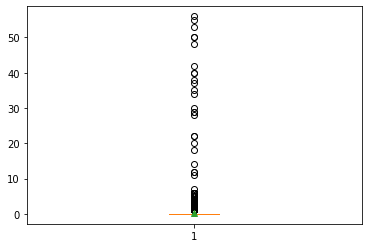

In [70]:
show_statistics(df_tweets, 'num_urls_conv')

In [71]:
df_tweets[df_tweets.num_urls_conv == df_tweets.num_urls_conv.max()]

,user_id,num_urls,created_at,text,retweet_count_conv,reply_count_conv,favorite_count_conv,num_hashtags_conv,num_urls_conv,num_mentions_conv,created_at_conv
380982,NaN,056,2020-02-25 05:59:48.000,HELP!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,0.0,0.0,0.0,0.0,56.0,0.0,1.582610e+18


In [72]:
df_tweets.drop(columns = ['num_urls'], inplace=True)

In [73]:
df_tweets.rename(columns={"retweet_count_conv": "retweet_count", "reply_count_conv": "reply_count", "favorite_count_conv": "favorite_count",
                          "num_hashtags_conv": "num_hashtags", "num_urls_conv": "num_urls", "num_mentions_conv": "num_mentions"}, inplace = True)

In [74]:
df_tweets = df_tweets.astype({"retweet_count": 'int32', "reply_count": 'int32', "favorite_count" : 'int32',
                          "num_hashtags": 'int32', "num_urls": 'int32', "num_mentions": 'int32'})

In [75]:
df_tweets.to_csv(path_or_buf='data/tweets_clean.csv', sep='#', index=False)




# Fine